In [1]:
from lammps import PyLammps
import numpy as np
from scipy.optimize import leastsq
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from dask import delayed
from distributed import Client, LocalCluster
import matplotlib.gridspec as gridspec

In [2]:
from stillingerweber.sw import Sw
from stillingerweber.lammps_routines import *

In [364]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38715 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 8.08 GB


In [371]:
cluster.close()

In [27]:
def complete_routine(sw):
    outfile = sw.tag + '.sw'
    sw.write(outfile)
    simbcc = {"structure": "bcc", "alat": 3.50, "reps":[1,1,1], "potfile": outfile, "mass": 28.08}
    simfcc = {"structure": "fcc", "alat": 3.50, "reps":[1,1,1], "potfile": outfile, "mass": 28.08}
    simdia = {"structure": "diamond", "alat": 5.00, "reps":[1,1,1], "potfile": outfile, "mass": 28.08}
    
    #find lattice constants
    lat = routine_lattice_constant(simbcc)
    simbcc["alat"] = lat
    lat = routine_lattice_constant(simfcc)
    simfcc["alat"] = lat
    lat = routine_lattice_constant(simdia)
    simdia["alat"] = lat
    
    #now calculate ev curve - then return min values
    vbcc, ebcc, efbcc = routine_ev_curve(simbcc)
    vfcc, efcc, effcc = routine_ev_curve(simfcc)
    vdia, edia, efdia = routine_ev_curve(simdia)
    
    #get the values from it
    abcc = np.argsort(efbcc)[0]
    ebccmin = efbcc[abcc]
    ebccvol = vbcc[abcc]

    afcc = np.argsort(effcc)[0]
    efccmin = effcc[afcc]
    efccvol = vfcc[afcc]

    adia = np.argsort(edia)[0]
    ediamin = efdia[adia]
    ediavol = vdia[adia]
    
    return [ebccmin, ebccvol, efccmin, efccvol, ediamin, ediavol]
    #return [efccmin, efccvol, ediamin, ediavol]

In [28]:
nums = 3
epsilon = np.linspace(0.5, 2, nums)
sigma = np.linspace(0.5, 3.0, nums)
a = np.linspace(1.0, 6.0, nums)
lmbda = np.linspace(0, 33, nums)

In [86]:
def delayed_routine(a1, a2, a3, a4):
    dd = {"epsilon": a1, "sigma": a2, "a": a3, "lambda": a4}
    tag = ".".join(np.array([a1, a2, a3, a4]).astype(str))
    sw = Sw(tag, params = dd)
    try:
        data = complete_routine(sw)
    except:
        data = [float('NaN'), float('NaN'), float('NaN'), float('NaN'), float('NaN'), float('NaN')]
    potd = [a1, a2, a3, a4]
    fulldata = potd + data
    return fulldata    

In [87]:
datas = []
for a1 in epsilon:
    for a2 in sigma:
        for a3 in a:
            for a4 in lmbda:
                data = delayed (delayed_routine) (a1, a2, a3, a4)
                datas.append(data)

In [88]:
datas = delayed (np.array) (datas)

In [89]:
res = datas.compute()

In [91]:
datas = np.array(res)

In [93]:

dfdata = {"epsilon": datas[:,0], "sigma": datas[:,1], "a": datas[:,2], "lambda": datas[:,3],
             "Ebcc": datas[:,4], "Vbcc": datas[:,5],
             "Efcc": datas[:,6], "Vfcc": datas[:,7],
             "Edia": datas[:,8], "Vdia": datas[:,9]}

In [94]:
df = pd.DataFrame(data = dfdata)

In [95]:
df.to_hdf("data_set_1.hdf", key='key')

In [96]:
df

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,0.5,0.5,1.0,0.0,NaN,20.800785,NaN,10.400392,NaN,15.160922
1,0.5,0.5,1.0,16.5,NaN,20.800785,NaN,10.400392,NaN,15.160922
2,0.5,0.5,1.0,33.0,NaN,20.800785,NaN,10.400392,NaN,15.160922
3,0.5,0.5,3.5,0.0,NaN,20.800785,NaN,10.400392,NaN,15.160922
4,0.5,0.5,3.5,16.5,NaN,20.800785,NaN,10.400392,NaN,15.160922
...,...,...,...,...,...,...,...,...,...,...
76,2.0,3.0,3.5,16.5,17927.435970,22.087078,72261.150689,11.043539,32305.774920,16.098453
77,2.0,3.0,3.5,33.0,36251.118251,22.087078,145264.218624,11.043539,65108.097371,16.098453
78,2.0,3.0,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
79,2.0,3.0,6.0,16.5,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
dfs = df.fillna(0)

In [116]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,0.5,0.5,1.0,0.0,0.000000,20.800785,0.000000,10.400392,0.000000,15.160922
1,0.5,0.5,1.0,16.5,0.000000,20.800785,0.000000,10.400392,0.000000,15.160922
2,0.5,0.5,1.0,33.0,0.000000,20.800785,0.000000,10.400392,0.000000,15.160922
3,0.5,0.5,3.5,0.0,0.000000,20.800785,0.000000,10.400392,0.000000,15.160922
4,0.5,0.5,3.5,16.5,0.000000,20.800785,0.000000,10.400392,0.000000,15.160922
...,...,...,...,...,...,...,...,...,...,...
76,2.0,3.0,3.5,16.5,17927.435970,22.087078,72261.150689,11.043539,32305.774920,16.098453
77,2.0,3.0,3.5,33.0,36251.118251,22.087078,145264.218624,11.043539,65108.097371,16.098453
78,2.0,3.0,6.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79,2.0,3.0,6.0,16.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [117]:
indexbcc = dfs[ dfs['Ebcc'] == 0 ].index
indexfcc = dfs[ dfs['Efcc'] == 0 ].index
indexdia = dfs[ dfs['Edia'] == 0 ].index

In [118]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [119]:
dfs.drop(indexall , inplace=True)

Filter energy above +100

In [121]:
indexbcc = dfs[ dfs['Ebcc'] > 100 ].index
indexfcc = dfs[ dfs['Efcc'] > 100 ].index
indexdia = dfs[ dfs['Edia'] > 100 ].index

In [122]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [123]:
dfs.drop(indexall , inplace=True)

Filter energy above +50

In [125]:
indexbcc = dfs[ dfs['Ebcc'] > 50 ].index
indexfcc = dfs[ dfs['Efcc'] > 50 ].index
indexdia = dfs[ dfs['Edia'] > 50 ].index

In [126]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [127]:
dfs.drop(indexall , inplace=True)

In [128]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
12,0.50,1.75,3.5,0.0,-18.289068,20.800785,-43.233490,10.400392,-30.953306,15.160922
15,0.50,1.75,6.0,0.0,-182.100368,20.800785,-338.227251,10.400392,-299.850508,15.160922
18,0.50,3.00,1.0,0.0,0.000000,20.800785,0.013293,11.043539,0.204926,16.098453
19,0.50,3.00,1.0,16.5,0.000000,20.800785,0.013393,11.043539,0.204926,16.098453
20,0.50,3.00,1.0,33.0,0.000000,20.800785,0.013493,11.043539,0.204926,16.098453
21,0.50,3.00,3.5,0.0,-119.254118,20.800785,-204.821815,10.400392,-136.817513,15.160922
39,1.25,1.75,3.5,0.0,-45.722670,20.800785,-108.083726,10.400392,-77.383266,15.160922
42,1.25,1.75,6.0,0.0,-455.250919,20.800785,-845.568128,10.400392,-749.626269,15.160922
45,1.25,3.00,1.0,0.0,0.000000,20.800785,0.033232,11.043539,0.512316,16.098453
46,1.25,3.00,1.0,16.5,0.000000,20.800785,0.033481,11.043539,0.512316,16.098453


### First rounder of filter

The parameters that would be varied are $\epsilon$, $\sigma$, $a$ and $\lambda$. The possible ranges for these parameters were identified based on existing literature.
The range are `1-2.5`, `1.75-3.0`, `1.0-3.5` and `0-33` respectively. $\lambda$ could further be increased.

In [129]:
nums = 4
epsilon = np.linspace(1, 2.5, nums)
sigma = np.linspace(1.75, 3.0, nums)
a = np.linspace(1.0, 3.5, nums)
lmbda = np.linspace(0, 33, nums)

In [130]:
datas = []
for a1 in epsilon:
    for a2 in sigma:
        for a3 in a:
            for a4 in lmbda:
                data = delayed (delayed_routine) (a1, a2, a3, a4)
                datas.append(data)

In [131]:
datas = delayed (np.array) (datas)

In [132]:
res = datas.compute()

In [133]:
datas = np.array(res)

In [134]:

dfdata = {"epsilon": datas[:,0], "sigma": datas[:,1], "a": datas[:,2], "lambda": datas[:,3],
             "Ebcc": datas[:,4], "Vbcc": datas[:,5],
             "Efcc": datas[:,6], "Vfcc": datas[:,7],
             "Edia": datas[:,8], "Vdia": datas[:,9]}

In [135]:
df = pd.DataFrame(data = dfdata)

In [136]:
df.to_hdf("data_set_2.hdf", key='key')

In [138]:
dfs = df.fillna(0)

In [139]:
indexbcc = dfs[ dfs['Ebcc'] == 0 ].index
indexfcc = dfs[ dfs['Efcc'] == 0 ].index
indexdia = dfs[ dfs['Edia'] == 0 ].index

In [140]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [141]:
dfs.drop(indexall , inplace=True)

Filter energues like before

In [143]:
indexbcc = dfs[ dfs['Ebcc'] > 50 ].index
indexfcc = dfs[ dfs['Efcc'] > 50 ].index
indexdia = dfs[ dfs['Edia'] > 50 ].index

In [144]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [145]:
dfs.drop(indexall , inplace=True)

Drop indices where at least one energy is not negative

In [147]:
indexbcc = dfs[ dfs['Ebcc'] > 0 ].index
indexfcc = dfs[ dfs['Efcc'] > 0 ].index
indexdia = dfs[ dfs['Edia'] > 0 ].index

In [148]:
indexall = list(set(indexbcc) & set(indexfcc) & set(indexdia))

In [149]:
dfs.drop(indexall , inplace=True)

Drop all enegeries less than -50 -> just scaling

In [151]:
indexbcc = dfs[ dfs['Ebcc'] < -50 ].index
indexfcc = dfs[ dfs['Efcc'] < -50 ].index
indexdia = dfs[ dfs['Edia'] < -50 ].index

In [152]:
indexall = list(set(indexbcc) & set(indexfcc) & set(indexdia))

In [153]:
dfs.drop(indexall , inplace=True)

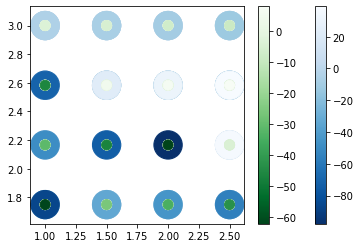

In [196]:
plt.scatter(dfs['epsilon'], dfs['sigma'], s=800, c=dfs['Efcc'],cmap='Blues_r')
plt.colorbar()
plt.scatter(dfs['epsilon'], dfs['sigma'], s=100, c=dfs['Edia'],cmap='Greens_r')
plt.colorbar()

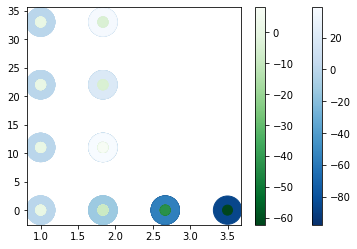

In [198]:
plt.scatter(dfs['a'], dfs['lambda'], s=800, c=dfs['Efcc'],cmap='Blues_r')
plt.colorbar()
plt.scatter(dfs['a'], dfs['lambda'], s=100, c=dfs['Edia'],cmap='Greens_r')
plt.colorbar()

We fix a = 1.8

In [199]:
nums = 4
epsilon = np.linspace(1, 2.5, nums)
sigma = np.linspace(1.75, 2.8, nums)
a = 1.8
lmbda = np.linspace(0, 33, nums)

In [200]:
datas = []
for a1 in epsilon:
    for a2 in sigma:
        for a4 in lmbda:
            data = delayed (delayed_routine) (a1, a2, 1.8, a4)
            datas.append(data)

In [201]:
datas = delayed (np.array) (datas)

In [202]:
res = datas.compute()

In [203]:
datas = np.array(res)

In [204]:

dfdata = {"epsilon": datas[:,0], "sigma": datas[:,1], "a": datas[:,2], "lambda": datas[:,3],
             "Ebcc": datas[:,4], "Vbcc": datas[:,5],
             "Efcc": datas[:,6], "Vfcc": datas[:,7],
             "Edia": datas[:,8], "Vdia": datas[:,9]}

In [205]:
df = pd.DataFrame(data = dfdata)

In [206]:
df.to_hdf("data_set_3.hdf", key='key')

In [207]:
dfs = df.fillna(0)

In [208]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,1.0,1.75,1.8,0.0,-0.000180,20.800785,-4.366215,10.400392,-1.892202,15.160922
1,1.0,1.75,1.8,11.0,-0.000180,20.800785,-2.403626,10.400392,-1.892202,15.160922
2,1.0,1.75,1.8,22.0,-0.000180,20.800785,-1.765715,10.483383,-1.892202,15.160922
3,1.0,1.75,1.8,33.0,-0.000180,20.800785,-1.349334,11.043539,-1.892202,15.160922
4,1.0,2.10,1.8,0.0,-1.803972,20.800785,-6.070926,10.400392,0.000000,16.098453
...,...,...,...,...,...,...,...,...,...,...
59,2.5,2.45,1.8,33.0,3.523028,22.087078,89.566072,11.043539,10.658699,16.098453
60,2.5,2.80,1.8,0.0,-16.347690,20.800785,-11.720441,11.043539,-7.474614,15.686637
61,2.5,2.80,1.8,11.0,3.274741,22.087078,67.283098,11.043539,25.012202,16.098453
62,2.5,2.80,1.8,22.0,23.481721,22.087078,146.286855,11.043539,57.753174,16.098453


In [209]:
indexbcc = dfs[ dfs['Ebcc'] > 30 ].index
indexfcc = dfs[ dfs['Efcc'] > 30 ].index
indexdia = dfs[ dfs['Edia'] > 30 ].index

In [210]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [211]:
dfs.drop(indexall , inplace=True)

In [212]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,1.0,1.75,1.8,0.0,-0.000180,20.800785,-4.366215,10.400392,-1.892202,15.160922
1,1.0,1.75,1.8,11.0,-0.000180,20.800785,-2.403626,10.400392,-1.892202,15.160922
2,1.0,1.75,1.8,22.0,-0.000180,20.800785,-1.765715,10.483383,-1.892202,15.160922
3,1.0,1.75,1.8,33.0,-0.000180,20.800785,-1.349334,11.043539,-1.892202,15.160922
4,1.0,2.10,1.8,0.0,-1.803972,20.800785,-6.070926,10.400392,0.000000,16.098453
...,...,...,...,...,...,...,...,...,...,...
58,2.5,2.45,1.8,22.0,-1.522532,22.087078,54.223243,11.043539,5.228334,16.098453
59,2.5,2.45,1.8,33.0,3.523028,22.087078,89.566072,11.043539,10.658699,16.098453
60,2.5,2.80,1.8,0.0,-16.347690,20.800785,-11.720441,11.043539,-7.474614,15.686637
61,2.5,2.80,1.8,11.0,3.274741,22.087078,67.283098,11.043539,25.012202,16.098453


In [213]:
indexbcc = dfs[ dfs['Ebcc'] > 20 ].index
indexfcc = dfs[ dfs['Efcc'] > 20 ].index
indexdia = dfs[ dfs['Edia'] > 20 ].index

In [214]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [215]:
dfs.drop(indexall , inplace=True)

Drop indices where at least one energy is not negative

In [217]:
indexbcc = dfs[ dfs['Ebcc'] > 0 ].index
indexfcc = dfs[ dfs['Efcc'] > 0 ].index
indexdia = dfs[ dfs['Edia'] > 0 ].index

In [218]:
indexall = list(set(indexbcc) & set(indexfcc) & set(indexdia))

In [219]:
dfs.drop(indexall , inplace=True)

In [228]:
labels = []
for i in range(len(dfs)):
    label = np.argsort([np.array(dfs["Ebcc"])[i], np.array(dfs["Efcc"])[i], np.array(dfs["Edia"])[i]])[0]
    labels.append(label)

In [231]:
dfs["labels"] = labels

In [256]:
dfs10 = dfs.loc[dfs['epsilon'] == 1.0]
dfs15 = dfs.loc[dfs['epsilon'] == 1.5]
dfs20 = dfs.loc[dfs['epsilon'] == 2.0]
dfs25 = dfs.loc[dfs['epsilon'] == 2.5]

Text(0, 0.5, '$\\lambda$')

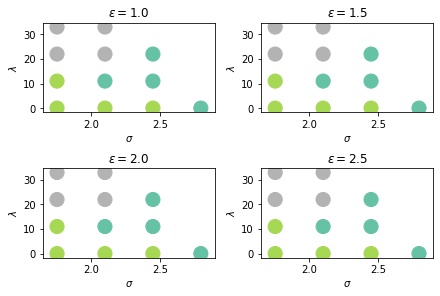

In [273]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(dfs10['sigma'], dfs10['lambda'], s=200, c=dfs10['labels'],cmap='Set2')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")

ax2 = fig.add_subplot(spec[0, 1])
ax2.scatter(dfs15['sigma'], dfs15['lambda'], s=200, c=dfs15['labels'],cmap='Set2')
ax2.set_title("$\epsilon=1.5$")
ax2.set_xlabel("$\sigma$")
ax2.set_ylabel("$\lambda$")

ax3 = fig.add_subplot(spec[1, 0])
ax3.scatter(dfs20['sigma'], dfs20['lambda'], s=200, c=dfs20['labels'],cmap='Set2')
ax3.set_title("$\epsilon=2.0$")
ax3.set_xlabel("$\sigma$")
ax3.set_ylabel("$\lambda$")

ax4 = fig.add_subplot(spec[1, 1])
ax4.scatter(dfs25['sigma'], dfs25['lambda'], s=200, c=dfs25['labels'],cmap='Set2')
ax4.set_title("$\epsilon=2.5$")
ax4.set_xlabel("$\sigma$")
ax4.set_ylabel("$\lambda$")

## $\sigma$ and $\lambda$ are the key parameters
## $\epsilon$ can scale the energy levels - but cannot change relative phase stability

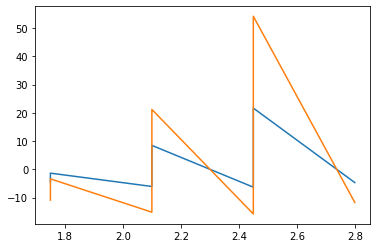

In [281]:
plt.plot(dfs10['sigma'], dfs10['Efcc'])
plt.plot(dfs25['sigma'], dfs25['Efcc'])

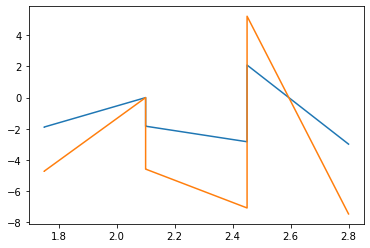

In [280]:
plt.plot(dfs10['sigma'], dfs10['Edia'])
plt.plot(dfs25['sigma'], dfs25['Edia'])

## $\epsilon$ are also to be fixed at 2.5 - and explore a finer mesh

In [282]:
nums = 30
epsilon = 2.5
sigma = np.linspace(1.75, 2.8, nums)
a = 1.8
lmbda = np.linspace(0, 33, nums)

In [283]:
datas = []
for a2 in sigma:
    for a4 in lmbda:
        data = delayed (delayed_routine) (2.5, a2, 1.8, a4)
        datas.append(data)

In [284]:
datas = delayed (np.array) (datas)

In [285]:
res = datas.compute()

In [286]:
datas = np.array(res)

In [287]:

dfdata = {"epsilon": datas[:,0], "sigma": datas[:,1], "a": datas[:,2], "lambda": datas[:,3],
             "Ebcc": datas[:,4], "Vbcc": datas[:,5],
             "Efcc": datas[:,6], "Vfcc": datas[:,7],
             "Edia": datas[:,8], "Vdia": datas[:,9]}

In [328]:
df = pd.DataFrame(data = dfdata)

In [289]:
df.to_hdf("data_set_4.hdf", key='key')

In [329]:
dfs = df.fillna(0)

In [330]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,2.5,1.75,1.8,0.000000,-0.000450,20.800785,-10.915537,10.400392,-4.730505,15.160922
1,2.5,1.75,1.8,1.137931,-0.000450,20.800785,-13.255273,10.400392,-4.730505,15.160922
2,2.5,1.75,1.8,2.275862,-0.000450,20.800785,-22.606685,10.400392,-4.730505,15.160922
3,2.5,1.75,1.8,3.413793,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
4,2.5,1.75,1.8,4.551724,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
...,...,...,...,...,...,...,...,...,...,...
895,2.5,2.80,1.8,28.448276,35.432043,22.087078,192.599405,11.043539,76.956953,16.098453
896,2.5,2.80,1.8,29.586207,37.545095,22.087078,200.772207,11.043539,80.346199,16.098453
897,2.5,2.80,1.8,30.724138,39.659122,22.087078,208.945010,11.043539,83.735521,16.098453
898,2.5,2.80,1.8,31.862069,41.774042,22.087078,217.117812,11.043539,87.124911,16.098453


In [331]:
indexbcc = dfs[ dfs['Ebcc'] > 20 ].index
indexfcc = dfs[ dfs['Efcc'] > 20 ].index
indexdia = dfs[ dfs['Edia'] > 20 ].index

In [332]:
indexall = list(set(indexbcc) & (set(indexfcc) | set(indexdia)))

In [333]:
dfs.drop(indexall , inplace=True)

In [334]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,2.5,1.75,1.8,0.000000,-0.000450,20.800785,-10.915537,10.400392,-4.730505,15.160922
1,2.5,1.75,1.8,1.137931,-0.000450,20.800785,-13.255273,10.400392,-4.730505,15.160922
2,2.5,1.75,1.8,2.275862,-0.000450,20.800785,-22.606685,10.400392,-4.730505,15.160922
3,2.5,1.75,1.8,3.413793,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
4,2.5,1.75,1.8,4.551724,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
...,...,...,...,...,...,...,...,...,...,...
883,2.5,2.80,1.8,14.793103,10.202730,22.087078,94.525769,11.043539,36.297464,16.098453
884,2.5,2.80,1.8,15.931034,12.291280,22.087078,102.698571,11.043539,39.684338,16.098453
885,2.5,2.80,1.8,17.068966,14.383453,22.087078,110.871381,11.043539,43.071624,16.098453
886,2.5,2.80,1.8,18.206897,16.478796,22.087078,119.044183,11.043539,46.459248,16.098453


In [335]:
indexbcc = dfs[ dfs['Ebcc'] < -20 ].index
indexfcc = dfs[ dfs['Efcc'] < -20 ].index
indexdia = dfs[ dfs['Edia'] < -20 ].index

In [336]:
indexall = list(set(indexbcc) & (set(indexfcc) & set(indexdia)))

In [337]:
dfs.drop(indexall , inplace=True)

In [338]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,2.5,1.75,1.8,0.000000,-0.000450,20.800785,-10.915537,10.400392,-4.730505,15.160922
1,2.5,1.75,1.8,1.137931,-0.000450,20.800785,-13.255273,10.400392,-4.730505,15.160922
2,2.5,1.75,1.8,2.275862,-0.000450,20.800785,-22.606685,10.400392,-4.730505,15.160922
3,2.5,1.75,1.8,3.413793,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
4,2.5,1.75,1.8,4.551724,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
...,...,...,...,...,...,...,...,...,...,...
883,2.5,2.80,1.8,14.793103,10.202730,22.087078,94.525769,11.043539,36.297464,16.098453
884,2.5,2.80,1.8,15.931034,12.291280,22.087078,102.698571,11.043539,39.684338,16.098453
885,2.5,2.80,1.8,17.068966,14.383453,22.087078,110.871381,11.043539,43.071624,16.098453
886,2.5,2.80,1.8,18.206897,16.478796,22.087078,119.044183,11.043539,46.459248,16.098453


In [339]:
labels = []
for i in range(len(dfs)):
    label = np.argsort([np.array(dfs["Ebcc"])[i], np.array(dfs["Efcc"])[i], np.array(dfs["Edia"])[i]])[0]
    labels.append(label)

In [340]:
dfs["labels"] = labels

Text(0, 0.5, '$\\lambda$')

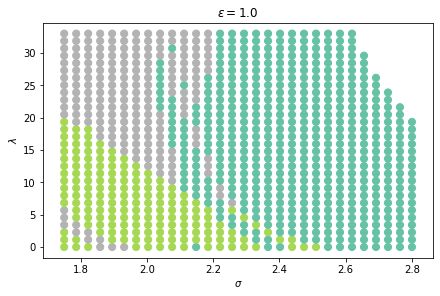

In [341]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(dfs['sigma'], dfs['lambda'], s=50, c=dfs['labels'],cmap='Set2')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")


In [342]:
dfbcc = dfs.loc[dfs['labels'] == 0]
dffcc = dfs.loc[dfs['labels'] == 1]
dfdia = dfs.loc[dfs['labels'] == 2]

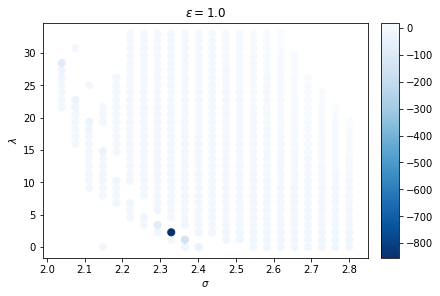

In [343]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
plt.scatter(dfbcc['sigma'], dfbcc['lambda'], s=50, c=dfbcc['Ebcc'],cmap='Blues_r')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")
plt.colorbar()

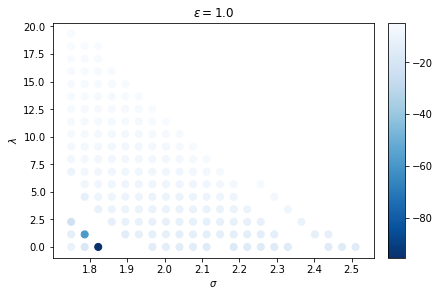

In [344]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
plt.scatter(dffcc['sigma'], dffcc['lambda'], s=50, c=dffcc['Efcc'],cmap='Blues_r')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")
plt.colorbar()

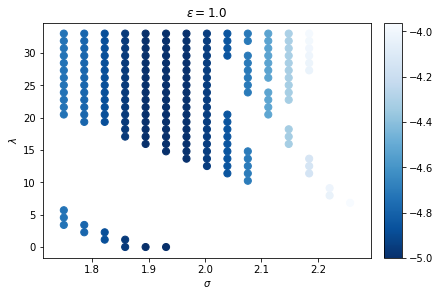

In [345]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
plt.scatter(dfdia['sigma'], dfdia['lambda'], s=50, c=dfdia['Edia'],cmap='Blues_r')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")
plt.colorbar()

### Promising - we go for a finer grid

In [365]:
nums = 50
epsilon = 2.5
sigma = np.linspace(1.75, 2.4, nums)
a = 1.8
lmbda = np.linspace(0, 33, nums)

In [372]:
datas = []
for a2 in sigma:
    for a4 in lmbda:
        data = delayed_routine(2.5, a2, 1.8, a4)
        datas.append(data)

100it [00:00, 331.43it/s]
100it [00:00, 302.65it/s]
100it [00:00, 336.02it/s]
100it [00:00, 340.81it/s]
100it [00:00, 327.83it/s]
100it [00:00, 335.32it/s]
100it [00:00, 332.20it/s]
100it [00:00, 327.36it/s]
100it [00:00, 324.75it/s]
100it [00:00, 260.12it/s]
100it [00:00, 302.39it/s]
100it [00:00, 325.47it/s]
100it [00:00, 322.84it/s]
100it [00:00, 291.12it/s]
100it [00:00, 319.51it/s]
100it [00:00, 326.02it/s]
100it [00:00, 316.79it/s]
100it [00:00, 324.84it/s]
100it [00:00, 314.54it/s]
100it [00:00, 312.76it/s]
/home/sarath/anaconda3/envs/sw/lib/python3.8/site-packages/stillingerweber-0.0.1-py3.8.egg/stillingerweber/lammps_routines.py:61: RuntimeWarning: invalid value encountered in power
100it [00:00, 304.34it/s]
100it [00:00, 324.97it/s]
100it [00:00, 290.98it/s]
100it [00:00, 310.45it/s]
100it [00:00, 310.89it/s]
100it [00:00, 301.40it/s]
100it [00:00, 316.39it/s]
100it [00:00, 313.67it/s]
100it [00:00, 294.50it/s]
100it [00:00, 311.42it/s]
100it [00:00, 258.53it/s]
100it [00:00,

In [373]:
res = datas

In [374]:
datas = np.array(res)

In [375]:

dfdata = {"epsilon": datas[:,0], "sigma": datas[:,1], "a": datas[:,2], "lambda": datas[:,3],
             "Ebcc": datas[:,4], "Vbcc": datas[:,5],
             "Efcc": datas[:,6], "Vfcc": datas[:,7],
             "Edia": datas[:,8], "Vdia": datas[:,9]}

In [376]:
df = pd.DataFrame(data = dfdata)

In [377]:
df.to_hdf("data_set_5.hdf", key='key')

In [353]:
dfs = df.fillna(0)

In [354]:
dfs

,epsilon,sigma,a,lambda,Ebcc,Vbcc,Efcc,Vfcc,Edia,Vdia
0,2.5,1.75,1.8,0.000000,-0.000450,20.800785,-10.915537,10.400392,-4.730505,15.160922
1,2.5,1.75,1.8,1.137931,-0.000450,20.800785,-13.255273,10.400392,-4.730505,15.160922
2,2.5,1.75,1.8,2.275862,-0.000450,20.800785,-22.606685,10.400392,-4.730505,15.160922
3,2.5,1.75,1.8,3.413793,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
4,2.5,1.75,1.8,4.551724,-0.000450,20.800785,0.000000,10.400392,-4.730505,15.160922
...,...,...,...,...,...,...,...,...,...,...
895,2.5,2.80,1.8,28.448276,35.432043,22.087078,192.599405,11.043539,76.956953,16.098453
896,2.5,2.80,1.8,29.586207,37.545095,22.087078,200.772207,11.043539,80.346199,16.098453
897,2.5,2.80,1.8,30.724138,39.659122,22.087078,208.945010,11.043539,83.735521,16.098453
898,2.5,2.80,1.8,31.862069,41.774042,22.087078,217.117812,11.043539,87.124911,16.098453


In [355]:
labels = []
for i in range(len(dfs)):
    label = np.argsort([np.array(dfs["Ebcc"])[i], np.array(dfs["Efcc"])[i], np.array(dfs["Edia"])[i]])[0]
    labels.append(label)

In [356]:
dfs["labels"] = labels

Text(0, 0.5, '$\\lambda$')

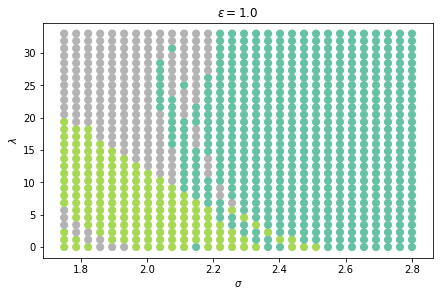

In [357]:
fig = plt.figure(constrained_layout=True)
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)

ax1 = fig.add_subplot(spec[0, 0])
ax1.scatter(dfs['sigma'], dfs['lambda'], s=50, c=dfs['labels'],cmap='Set2')
ax1.set_title("$\epsilon=1.0$")
ax1.set_xlabel("$\sigma$")
ax1.set_ylabel("$\lambda$")
